# Parkinson's Disease Classification Using "2.5D" Slices from 3T T1-weighted MRI Images

by: Gani Perez

@GitHub: GaniPerez

This project hopes to develop a neural network to classify Parkinson's Disease patients by "2.5D" slices from T1-weighted MRIs. It is largely inspired by a slew of positive and negative studies finding differences (or no differences) between the MRIs of Parkinson's patients vs healthy controls. In previous papers, including [here](https://www.sciencedirect.com/science/article/abs/pii/S1353802008001521), [here](https://pubmed.ncbi.nlm.nih.gov/25628916/), and [here](https://www.frontiersin.org/articles/10.3389/fneur.2019.01329/full) (among others) largely show a failure to find volume-based differences between various regions of the brain, but show scattered and inconsistent differences in voxel-based morphometry of particular brain regions, including the [putamen](https://pubmed.ncbi.nlm.nih.gov/25628916/), [hippocampus and striatum](https://www.frontiersin.org/articles/10.3389/fneur.2017.00139/full), [caudate nucleus](https://pubmed.ncbi.nlm.nih.gov/29962342/), [amygdala](https://www.frontiersin.org/articles/10.3389/fneur.2019.01329/full), [nucleus accumbens](https://pubmed.ncbi.nlm.nih.gov/24817690/), [pallidum and thalamus](https://www.frontiersin.org/articles/10.3389/fnins.2015.00101/full). Frankly, the literature is all over the place.

Most of these differences among brain regions were found as subtle changes to cell density and regional morphology, both of which may be found via a T1-weighted MRI. Thus, this workflow hopes to use a neural network to identify some of these potential differences and use them to distinguish between PD patients and controls.

It's important to note that T1-weighted MRIs are not typically used for the diagnosis or confirmation of PD. If imaging is done to augment a diagnosis, it is usually a resting-state fMRI, PET, or echosonogram. Unfortunately, fMRI technology has low resolution, is expensive and inconvenient, and has high variability (it requires a patient to stay still for 5-15 minutes in an MRI machine). On the other hand, echosonography is inconsistent, requires very specialized training, and is sensitive to small differences in skull shape between patients. While PET studies have the highest chance to show the dopaminergic deficit in PD, they are also invasive, expensive, and often trigger painful allergic reactions (they require the injection of radioactive tracers). None of these options are particularly suitable for a screening approach. On the other hand, T1-weighted MRIs are quick, much less invasive, and the technology is more readily available. However, as described above, the literature is extremely conflicted whether any differences exist between the T1-weighted MRIs of patients and healthy controls.

## The Workflow Structure

The workflow takes a T1-weighted MRI image and uses another available neural network called [MALPEM](https://github.com/ledigchr/MALPEM) to infer voxel coordinates corresponding to a brain region of interest. Then, it randomly subsamples 50 of these coordinates, as long as they are separated by a block of 5 voxels. Of these samples, it extracts three 32x32 images, corresponding to the coronal, sagittal, and axial cut centering on that voxel coordinate. From there, it overlays these 3 images to form a single RGB image "subsample," which is then processed by the neural network below. 

### How cuts are performed

After subsampling, the way images are constructed from a voxel coordinate is described below. This comes from [this paper](https://www.frontiersin.org/articles/10.3389/fnins.2018.00777/full).

![alt_text](subsample_cuts_example.png "Subsampling")


#### Why this workflow? Why subsample?
My choice to subsample small cuts from the entire 3D MRI is probably one of the most controversial choices in this workflow. The decision is largely borne from technical limitations: first off, my image library only consists of 36 healthy controls and 47 patients, and I was not sure if I was comfortable running a neural network with these lower number of samples, relative to the number of dimensions in my data. Second, my computer's GPU doesn't have the available VRAM to perform tensor operations on large 3D images, and I wanted to refrain from using Biowulf as I wanted to learn how to run this on my computer (since I won't be at the NIH forever)! Last, I was relatively comfortable with this decision because of a few scientific facts:
1. Most studies cited atrophy in relevant areas primarily due to loss of dopamine from connected dopaminergic neurons. This sort of atrophy would affect almost all of the regions in question, ensuring that any given "cut" should have signs of this occurring.
2. Thirty-two voxels is actually a good distance which seems to cover a good portion of each region in question.
3. I wanted to introduce some degree of constancy into my neural network, as I am interested in whether the *entirety* of these regions display morphological changes due to PD. If our model can differentiate between PD and control even despite different views of the region, I am satisfied that such differences actually exist between PD and control.

In reality, I am not confident that we will be able to distinguish between PD and control images using this method, as I am very skeptical about the findings of the above literature. Thus, working with more images (and putting together the preprocessing workflow) is also a training exercise for me, and will hopefully prepare me to do more involved data preprocessing like this in the future.

## Loading the Data

This set of cells loads the data.

In [1]:
import numpy as np
import MRIs
import os
%matplotlib inline
from datetime import datetime

The MRI_input_array is an object holding train, validation, and test image sets. If these image sets don't yet exist, they can create them by calling the referenced MRI_Img object. It takes four parameters: input_dir, output_dir, load_dir, and region. The other two (n and strides) are optional, and determine how many subsamples are generated, and how many voxels apart the subsamples are. Defaults are 150 and 3.

This first cell creates a new set of images, if they don't exist. input_dir, output_dir, and region are all that is needed. Currently, 7 regions are supported: amygdala, putamen, hippocampus, NAc (nucleus accumbens), thalamus, caudate nucleus, and pallidum.

In [2]:
now = datetime.now()
date_time = now.strftime("%m_%d_%Y__%H_%M_%S")

obj = MRIs.MRI_input_array(input_dir="./finished_runs", output_dir="./hippocampus_n50_s5__" + date_time + "/", region='hippocampus', n=50, strides=5)

created output directory, continuing...


TypeError: __init__() got an unexpected keyword argument 'region'

However, if you've already created your set of images, you may simply load them with the below command. The only parameter needed is load_dir, leading to the location of these subsample directories.

In [5]:
obj = MRIs.MRI_input_array(load_dir = "./amygdala_n50_s5__12_08_2021__22_40_37/")

imgs: 4150
num control: 1800
num patient: 2350
4150
train size: 3320
validation size: 415
test size: 415
Finished loading images into object.


### WARNING: Important

If you are reading this cell, this means that I haven't yet fixed the database structure for the subsample pictures. This means that every time you reload the input data with the MRI_input_array() initialization, it generates new random values for segregating the train-validation-test data. A reproducibility nightmare! This means that you can expect slightly different results after each run through the notebook. More importantly, this means that you CANNOT load a previously-tuned model here, as most of the current test set was likely part of the training set when the model was originally trained. Finally, this means that you will likely not reproduce the exact values that I achieved (including specific hyperparameters when tuning). I guess I have accidentally done k-fold cross validation! This will be fixed soon, but is worth noting in case the model architecture arrives at a different accuracy, or the hyperparameter tuner arrives at a vastly different set of hyperparameters.

Back to the regularly scheduled programming... this is a simple test to check whether the dataset is of the correct shape. It should be (num images, dimensions of flat array).

In [6]:
obj.train_x[:,:].shape

(3320, 3072)

Now to set some variables for convenience...

In [7]:
img_size = obj.img_size
img_size_flat = obj.img_size_flat
num_channels = obj.num_channel
img_shape_full = obj.img_shape_full
num_classes = obj.num_classes

Now to check whether the computer is handling the GPU as intended...

In [14]:
from tensorflow.keras.layers import InputLayer, Input, Reshape, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout
from tensorflow.config.experimental import list_physical_devices
from tensorflow.python.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.math import confusion_matrix

In [7]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
;

2021-12-09 16:05:28.813451: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 16:05:29.035465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-09 16:05:29.056592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-09 16:05:29.056841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built witho

''

In [8]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
print("GPUs: ", len(list_physical_devices('GPU')))

GPUs:  1


2021-12-09 16:05:29.586936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-09 16:05:29.587203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-09 16:05:29.587424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


### Setting up the Neural Network Architecture

For now, my naive neural network has 3 convolution layers and three dense layers. First, the network is fed a variable array of the size (batch_size, img_size_flat). From there, it reshapes each image into a (32,32,3) array, such that the new tensor size is (None, 32, 32, 3). From there, it performs 1) convolution followed by linear activation and max pooling, 2) convolution followed by relu activation and average pooling, and 3) convolution followed by relu activation and average pooling. At this point, the data is flattened, and then passed through three dense layers: 1) 100 neurons with relu activation, 2) 100 neurons with relu activation, 3) 20 neurons with relu activation. Finally, it is fed into 2 output neurons with softmax activation.

Despite the fact that this model matches what was used for convolution in Lin et al. 2018, it performs surprisingly poorly on this dataset. I also had to change the activation in the first layer from 'relu' to 'linear' because I was entering a "relu hell" where most of the features were seemingly zeroed out.

In [9]:
# We'll start by creating an input function. Note that we are not creating a model object and
# adding the layers to the model object; we are calling the inside function directly.
inputs = Input(shape=(img_size_flat,))

# Variable used for building the neural network
net = inputs

# Reshaping input
reshape = Reshape(img_shape_full)   # Here, we're creating an object that consists of the Reshape command: specifically,
                                    # reshaping to the shape of (32,32,3).

net = reshape(net)                  # Since reshape is a callable object, we will call it.

# In practice, it's faster to instead simply type:
# net = Reshape(img_shape_full)(net).
# Instead of assigning Reshape(img_shape_full) to a pointer, we're simply re-calling the object immediately.

# 1st Convolutional Layer
net = Conv2D(kernel_size=(5,5), strides=1, filters=16, padding='same',
             activation='linear', name='layer_conv1')(net)
net = MaxPooling2D(pool_size=(3,3), strides=2)(net)

# 2nd Convolutional Layer
net = Conv2D(kernel_size=(5,5), strides=1, filters=16, padding='same',
             activation='relu', name='layer_conv2')(net)
net = AveragePooling2D(pool_size=(3,3), strides=2)(net)

net = Conv2D(kernel_size=(5,5), strides=1, filters=32, padding='same',
             activation='relu', name='layer_conv3')(net)
net = AveragePooling2D(pool_size=(3,3), strides=2)(net)

# Flatten
net = Flatten()(net)

# Dropout
net = Dropout(rate=0.3)(net)

# 2nd Dense Layer
net = Dense(100, activation='relu')(net)

# 3rd Dense Layer
net = Dense(100, activation='relu')(net)

net = Dense(20, activation='relu')(net)

# 4th Dense Layer
net = Dense(2, activation='softmax')(net) # may use logistic activation here

# setting our output to the result of this network
outputs = net

2021-12-09 16:05:36.015394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-09 16:05:36.015744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-09 16:05:36.016110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-09 16:05:36.016502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-09 16:05:36.016514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1609] Could not ident

Now to initialize and compile our model. For now, I'll use a learning rate of 0.001 and binary cross-entropy as the loss function. The optimizer uses stochastic gradient descent algorithm with adaptive moments (ADAM). ADAM tends to overshoot at first but still converges much faster than the standard sgd algorithm. Everything's written into Keras so it's very easy to generate and compile the model.

In [10]:
from tensorflow.python.keras.optimizer_v2.adam import Adam

# This will create an instance of our model.
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3),
               loss='binary_crossentropy',
               metrics=['accuracy'])

### Training and Fitting

We'll set a counter here to record how many total epochs we have trained with.

In [11]:
epochs = 0

To train:

In [13]:
run_epochs = 18

model.fit(x=obj.train_x,
          y=obj.train_y,
          epochs=run_epochs, batch_size=64)

epochs += run_epochs
print("Total epochs: " + str(epochs))

Epoch 1/18
52/52 [==============================] - 0s 9ms/step - loss: 0.6311 - accuracy: 0.6413
Epoch 2/18
52/52 [==============================] - 0s 9ms/step - loss: 0.6205 - accuracy: 0.6497
Epoch 3/18
52/52 [==============================] - 0s 5ms/step - loss: 0.6144 - accuracy: 0.6617
Epoch 4/18
52/52 [==============================] - 0s 5ms/step - loss: 0.5981 - accuracy: 0.6732
Epoch 5/18
52/52 [==============================] - 0s 5ms/step - loss: 0.5717 - accuracy: 0.7000
Epoch 6/18
52/52 [==============================] - 0s 5ms/step - loss: 0.5571 - accuracy: 0.7066
Epoch 7/18
52/52 [==============================] - 0s 5ms/step - loss: 0.5348 - accuracy: 0.7193
Epoch 8/18
52/52 [==============================] - 0s 5ms/step - loss: 0.5238 - accuracy: 0.7304
Epoch 9/18
52/52 [==============================] - 0s 6ms/step - loss: 0.5106 - accuracy: 0.7386
Epoch 10/18
52/52 [==============================] - 0s 6ms/step - loss: 0.4817 - accuracy: 0.7596
Epoch 11/18
52/52 [

Now that the model has been trained, I'm going to evaluate it on the validation set. To assess the number of epochs, you may consider running 1-2 epochs at a time and evaluating on the validation dataset after each time, to track whether the validation loss is decreasing. More on this later. I didn't show you the process of doing that (which would be long and tedious), so rest assured that the number of epochs is about enough to minimize the validation loss.

In [14]:
results = model.evaluate(x = obj.validation_x, y = obj.validation_y)

for name, value in zip(model.metrics_names, results):
    print(name, value)

13/13 [==============================] - 0s 14ms/step - loss: 0.8880 - accuracy: 0.6169
loss 0.8880274295806885
accuracy 0.6168674826622009


This will show us a summary of our model. Because it's not called sequentially, it doesn't show the individual layers here. However, we can see the number of trainable parameters.

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 61,526
Trainable params: 61,526
Non-trainable params: 0
_________________________________________________________________


Next, let's see how the model's predictions lined up with the actual test data. We will call model.predict() in order to receive predictions from the model -- these predictions are in the form [p_control, p_PD]. From here, we will do np.argmax() over the column axis in order to take the highest of the p-values -- this represents the class prediction. Thus, y_pred is a 1D array of class predictions, 0 or 1.

In [16]:
y_pred = np.argmax(model.predict(x=obj.test_x),axis=1)  

These next two cells are helper functions within the MRIs module -- they allow us to plot images with their true class and predicted class. Plot_example_errors shows us a random set of 9 pictures whose predicted class didn't match up with the true class.

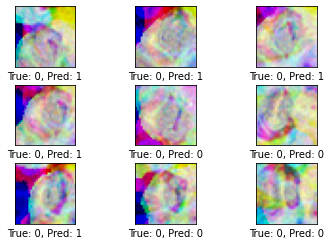

In [17]:
MRIs.plot_images(images=obj.test_x[0:9], cls_true=np.argmax(obj.test_y[0:9], axis=1), cls_pred=y_pred[0:9]) 

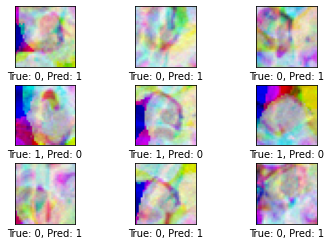

In [19]:
MRIs.plot_example_errors(obj, cls_pred=y_pred)

Finally, let's calculate the confusion matrix of our naive model.

In [12]:
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix = np.asarray(conf_matrix)
conf_matrix

NameError: name 'confusion_matrix' is not defined

In [ ]:
test_model_stats(conf_matrix)

## Tuning Hyperparameters

The above model was a naive model -- I followed the general schematic of Lin et al. 2018 but didn't have any particular rationale for choosing this network architecture over another. Because our data is different, I'd like to tune the hyperparameters to find a more optimal network architecture for my data.

I will use the keras tuner. Unfortunately, there doesn't seem to be a keras tuner in the keras build in tensorflow, so we will switch to pure keras for the hyperparameter tuning. Since the tensorflow implementation of keras is essentially a clone, I don't feel too worried that these will give different results.

In [17]:
# re-importing everything from keras native.
import keras_tuner as kt
from keras.callbacks import EarlyStopping
from keras.layers import InputLayer, Input, Reshape, MaxPooling2D, AveragePooling2D
from keras.layers import Conv2D, Dense, Flatten, Dropout
from keras.models import Model
from keras.optimizer_v2.adam import Adam

This defines a function we will use to build models with different hyperparameters. These are the hyperparameters to be tuned:

- Number of convolution layers: [1:3:]
- Number of convolution kernels: [8:40:8]
- Dropout rate: [0.1:0.5:0.1]
- Number of dense layers: [1:4:]
- Number of neurons per dense layer: [75:225:25]
- Number of neurons in final dense layer: [10:110:10]
- Learning rate: 0.01, 0.001, or 0.0001

In [9]:
def model_builder(hp):
    
    inputs = Input(shape=(img_size_flat,))
    net = inputs
    
    reshape = Reshape(img_shape_full)
    net = reshape(net)
    
    conv_layers = hp.Int('conv_layers', min_value=1, max_value=2, step=1)
    kernel_num = hp.Int('kernels', min_value=8, max_value=32, step=8)
    for i in range(0, conv_layers):
        layer_num = "layer_conv" + str(i)
        net = Conv2D(kernel_size=(5,5), strides=1, filters=kernel_num, padding='same',
             activation='relu', name=layer_num)(net)
        net = MaxPooling2D(pool_size=(3,3), strides=2)(net)
    
    # Flatten
    net = Flatten()(net)
    
    dropout_rate = hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)
    # Dropout
    net = Dropout(rate=0.3)(net)
    
    dense_layers = hp.Int('dense_layers', min_value=1, max_value=3, step=1)
    neurons = hp.Int('neurons', min_value=75, max_value=200, step=25)
    
    for i in range(0, dense_layers):
        net = Dense(neurons, activation='relu')(net)
    
    neurons2 = hp.Int('neurons2', min_value=10, max_value=100, step=10)
    net = Dense(neurons2, activation='relu')(net)
    net = Dense(2, activation='softmax')(net)
    outputs = net
    
    model = Model(inputs=inputs, outputs=outputs)
    
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

Next, we will instantiate our tuner. Make sure to change the "directory" parameter to a directory that is empty! Otherwise, the tuner will automatically exit.

In [10]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory='./tuning',
                     project_name='MRI_PD')
stop_early = EarlyStopping(monitor='val_loss', patience=5)

2021-12-11 19:17:00.791347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-11 19:17:00.813745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-11 19:17:00.814192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-11 19:17:00.814700: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

This tuner does bayesian optimization with the hyperparameters of the search space. Instead of searching through each set to 50 epochs, it is programmed to stop searching a particular set of hyperparameters if the validation loss does not decrease substantially by 5 epochs.

In [11]:
tuner.search(obj.train_x, obj.train_y, epochs=15, validation_split=0.2, callbacks=[stop_early])

Trial 90 Complete [00h 00m 07s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.14909638464450836
Total elapsed time: 00h 03m 57s
INFO:tensorflow:Oracle triggered exit


In [15]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. 
conv_layers: {best_hps.get('conv_layers')}
kernels: {best_hps.get('kernels')}
dropout: {best_hps.get('dropout')}
dense_layers: {best_hps.get('dense_layers')}
neurons: {best_hps.get('neurons')}
neurons2: {best_hps.get('neurons2')}
learning rate: {best_hps.get('learning_rate')}
""")


The hyperparameter search is complete. 
conv_layers: 1
kernels: 16
dropout: 0.2
dense_layers: 2
neurons: 150
neurons2: 40
learning rate: 0.001



Next, let's figure out the optimal number of epochs to run.

In [18]:
# builds model with the best hyperparameters from above tuning.
model = tuner.hypermodel.build(best_hps)
history = model.fit(obj.train_x, obj.train_y, epochs=50, validation_split=0.2)

Epoch 1/50
83/83 [==============================] - 1s 8ms/step - loss: 0.6193 - accuracy: 0.7063 - val_loss: 1.5310 - val_accuracy: 0.0000e+00
Epoch 2/50
83/83 [==============================] - 0s 4ms/step - loss: 0.5716 - accuracy: 0.7108 - val_loss: 2.6702 - val_accuracy: 0.0000e+00
Epoch 3/50
83/83 [==============================] - 0s 4ms/step - loss: 0.5596 - accuracy: 0.7274 - val_loss: 1.8794 - val_accuracy: 0.0015
Epoch 4/50
83/83 [==============================] - 0s 4ms/step - loss: 0.5172 - accuracy: 0.7594 - val_loss: 1.7082 - val_accuracy: 0.0557
Epoch 5/50
83/83 [==============================] - 0s 4ms/step - loss: 0.5256 - accuracy: 0.7492 - val_loss: 1.8110 - val_accuracy: 0.0045
Epoch 6/50
83/83 [==============================] - 0s 6ms/step - loss: 0.5169 - accuracy: 0.7541 - val_loss: 1.7215 - val_accuracy: 0.0346
Epoch 7/50
83/83 [==============================] - 1s 6ms/step - loss: 0.4869 - accuracy: 0.7828 - val_loss: 1.9382 - val_accuracy: 0.0060
Epoch 8/50
8

In [19]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 30


## Rebuilding the optimized model

Now that we have optimized hyperparameters, we can rebuild our model using these parameters. Note that the optimization method may not be the best -- I suspect that some more optimal hyperparameter sets may have been filtered out due to a low patience value (patience=5). It seems like the models require around 10-so epochs just to get going, so it may be worth increasing the patience to 12-15. Tuning will run significantly longer though!

Note that you can rebuild the model with the optimized parameters simply by running:
```tuner.hypermodel.build(best_hps)```. I just rewrote it instead to visualize the model structure.

In [69]:
from tensorflow.keras.layers import InputLayer, Input, Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout
from tensorflow.config.experimental import list_physical_devices
from tensorflow.python.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

In [70]:
# We'll start by creating an input function. Note that we are not creating a model object and
# adding the layers to the model object; we are calling the inside function directly.
inputs = Input(shape=(img_size_flat,))

# Variable used for building the neural network
net = inputs

# Reshaping input
reshape = Reshape(img_shape_full)   # Here, we're creating an object that consists of the Reshape command: specifically,
                                    # reshaping to the shape of (32,32,3).

net = reshape(net)                  # Since reshape is a callable object, we will call it.

# In practice, it's faster to instead simply type:
# net = Reshape(img_shape_full)(net).
# Instead of assigning Reshape(img_shape_full) to a pointer, we're simply re-calling the object immediately.

# 1st Convolutional Layer
net = Conv2D(kernel_size=(5,5), strides=1, filters=16, padding='same',
             activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=(3,3), strides=2)(net)

# Flatten
net = Flatten()(net)

# Dropout
net = Dropout(rate=0.2)(net)

# 1st Dense Layer
net = Dense(150, activation='relu')(net)

# 2nd Dense Layer
net = Dense(150, activation='relu')(net)

# 3rd Dense Layer
net = Dense(40, activation='relu')(net)

# 4th Dense Layer (output)
net = Dense(2, activation='softmax')(net) # may use logistic activation here

# setting our output to the result of this network
outputs = net

In [71]:
from tensorflow.python.keras.optimizer_v2.adam import Adam

# This will create an instance of our model.
model_tuned = Model(inputs=inputs, outputs=outputs)

model_tuned.compile(optimizer=Adam(learning_rate=1e-3),
               loss='binary_crossentropy',
               metrics=['accuracy'])

Now that the model has been compiled, let's run it again over the selected number of epochs.

In [53]:
epochs = 0

In [54]:
run_epochs = 30

model_tuned.fit(x=obj.train_x,
          y=obj.train_y,
          epochs=run_epochs, batch_size=64)

epochs += run_epochs
print("Total epochs: " + str(epochs))

Epoch 1/30
52/52 [==============================] - 1s 13ms/step - loss: 0.6906 - accuracy: 0.5461
Epoch 2/30
52/52 [==============================] - 0s 7ms/step - loss: 0.6835 - accuracy: 0.5660
Epoch 3/30
52/52 [==============================] - 0s 5ms/step - loss: 0.6817 - accuracy: 0.5717
Epoch 4/30
52/52 [==============================] - 0s 5ms/step - loss: 0.6719 - accuracy: 0.5943
Epoch 5/30
52/52 [==============================] - 0s 5ms/step - loss: 0.6482 - accuracy: 0.6340
Epoch 6/30
52/52 [==============================] - 0s 5ms/step - loss: 0.6295 - accuracy: 0.6461
Epoch 7/30
52/52 [==============================] - 0s 5ms/step - loss: 0.6188 - accuracy: 0.6554
Epoch 8/30
52/52 [==============================] - 0s 5ms/step - loss: 0.6034 - accuracy: 0.6741
Epoch 9/30
52/52 [==============================] - 0s 4ms/step - loss: 0.5662 - accuracy: 0.7063
Epoch 10/30
52/52 [==============================] - 0s 5ms/step - loss: 0.5166 - accuracy: 0.7428
Epoch 11/30
52/52 

Let's look at some basic properties of the model, as well as its performance on the validation set. Note that because I am building a functional model (not a sequential model), the ```summary()``` function does not give information on each individual layer.

In [25]:
model_tuned.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 570,138
Trainable params: 570,138
Non-trainable params: 0
_________________________________________________________________


In [26]:
results = model_tuned.evaluate(x = obj.validation_x, y = obj.validation_y)

for name, value in zip(model_tuned.metrics_names, results):
    print(name, value)

13/13 [==============================] - 0s 19ms/step - loss: 1.3710 - accuracy: 0.7518
loss 1.3709734678268433
accuracy 0.7518072128295898


Finally, let's assess the model's performance on the test set.

In [27]:
test_results = model_tuned.evaluate(x = obj.test_x, y = obj.test_y)

13/13 [==============================] - 0s 7ms/step - loss: 1.3965 - accuracy: 0.7446


In [28]:
y_pred = np.argmax(model_tuned.predict(x=obj.test_x), axis=1)
y_true = np.argmax(obj.test_y, axis=1)

In [42]:
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix = np.asarray(conf_matrix)
conf_matrix

array([[128,  60],
       [ 46, 181]], dtype=int32)

In [39]:
MRIs.test_model_stats(conf_matrix)

Accuracy =	0.744578313253012
Precision =	0.7510373443983402
Sensitivity =	0.7973568281938326
Specificity =	0.6808510638297872


(0.744578313253012, 0.7510373443983402, 0.7973568281938326, 0.6808510638297872)

In [46]:
auc = AUC()
auc.update_state(y_true, y_pred)
auc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.739104>

Now to plot some images, and error images:

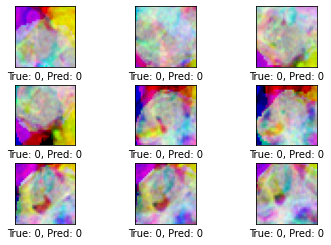

In [40]:
MRIs.plot_images(images=obj.test_x[0:9], cls_true=y_true[0:9], cls_pred=y_pred[0:9]) 

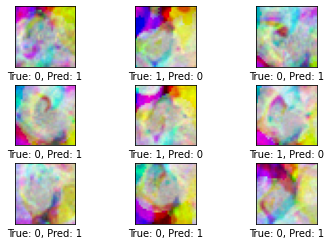

In [41]:
MRIs.plot_example_errors(data=obj, cls_pred=y_pred)

# Conclusion

So we've created a model which appears to have ~73% test accuracy, with ~79% and ~76% precision and accuracy, respectively. Because both training data and test data come from different subsample cuts from the same patients, there are a few large experimental design flaws that need working out. First, instead of splitting individual images into training-validation-test, I should split patients instead, to see whether the patterns our model architecture identifies are generalizing to PD. Furthermore, there is still a reproducibility issue to fix regarding the train-validation-test splitting! Finally, I will have to give the option to set a seed so that the random generation of subsamples/splits is reproducible.

Ta-dah! This concludes the tutorial on how to run this workflow. Please feel free to ask more questions by sending me an email at gani.perez@gmail.com, or creating an issue on the associated git repository. I'll get to it as soon as I figure out how to use git. Thanks!